In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate

In [2]:
from rg_dataset import LRG

In [3]:
from b_vae_trainer_multi import VAE, RotVAE

In [4]:
lrg_data_set = LRG(use_kittler=True, blur=True)

data_loader_lrg   = data.DataLoader(lrg_data_set, batch_size=64, shuffle=False)

sample = iter(data_loader_lrg).next()

LRG:	1442/1442


In [5]:
device = 'cuda'
lt_dim = 6
# fixed values #
epochs, gam, cap = 50, 8, 20
###############
model_name = 'trained_models/b_vae_rot_unlrg_g{}_ld{}_epochs{}_cap{}'.format(gam, lt_dim, epochs, cap)
vae = torch.load(model_name, map_location = device)
vae = vae.eval()

In [6]:
def rotate_tensor(input, angles):
    input = input.cpu()
    """ Somewhat hacky. Needs to be paralelized and implemented in pytorch!"""
    output = []
    for i in range(input.shape[0]): #basically batch_sizs
        out = rotate(input[i, ...], 360*angles[i], axes=(1, 2), reshape=False)
        output.append(out)
    return torch.FloatTensor(np.stack(output, 0))

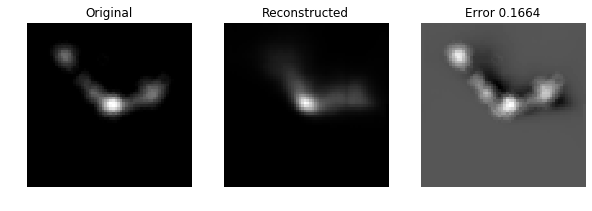

In [21]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e[:,:-1])
    rot = torch.sigmoid(e[:,-1])
    s = rotate_tensor(d, -rot)
    
s_n = s.numpy() - s.numpy().min()
bce = F.binary_cross_entropy(torch.FloatTensor(s_n[0][0]), d.cpu())

f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0], cmap='gray')
ax[1].imshow(d.cpu()[0][0], cmap='gray')
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('Original')
ax[1].set_title('Reconstructed')
ax[2].set_title('Error {:.4f}'.format(bce))

plt.show()

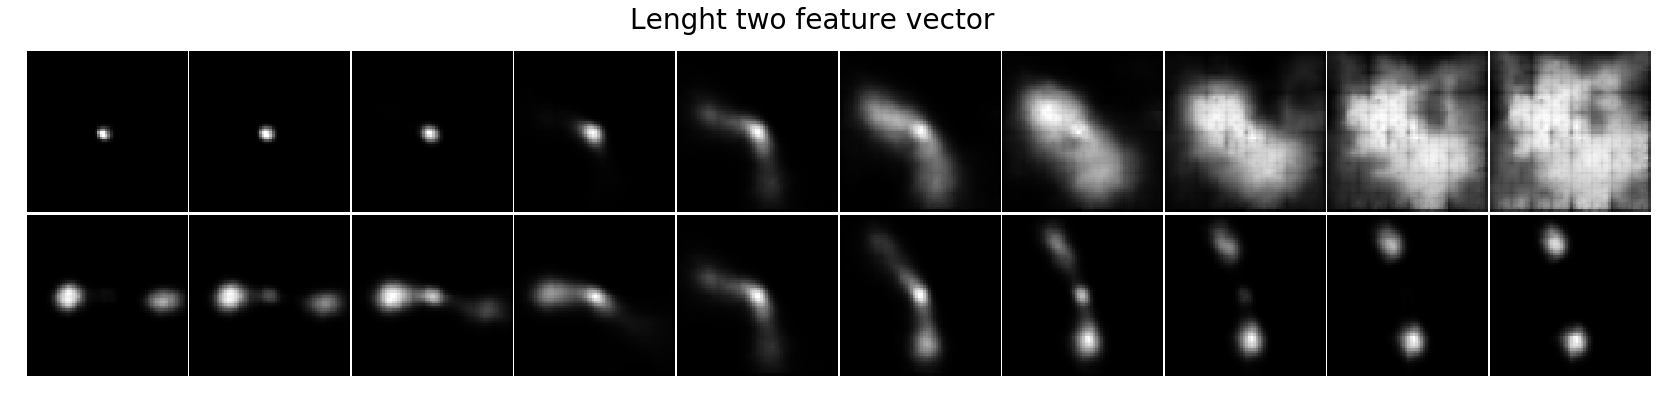

In [43]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]

r = 10
nimg = r * 2
k = 1
m = 1

fig = plt.figure(figsize=(29.1, 6))
fig.suptitle('Lenght two feature vector', fontsize=28)
gs1 = gridspec.GridSpec(2, r, figure=fig)
gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 

for i in range(2):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = vae.encode(s.to(device))[0][0]
            v = e[i]
            nv = -4*k + v + k*j
            e[i] = nv
            e = e[:-1]
#             print(e[:-1].shape)
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

plt.show()

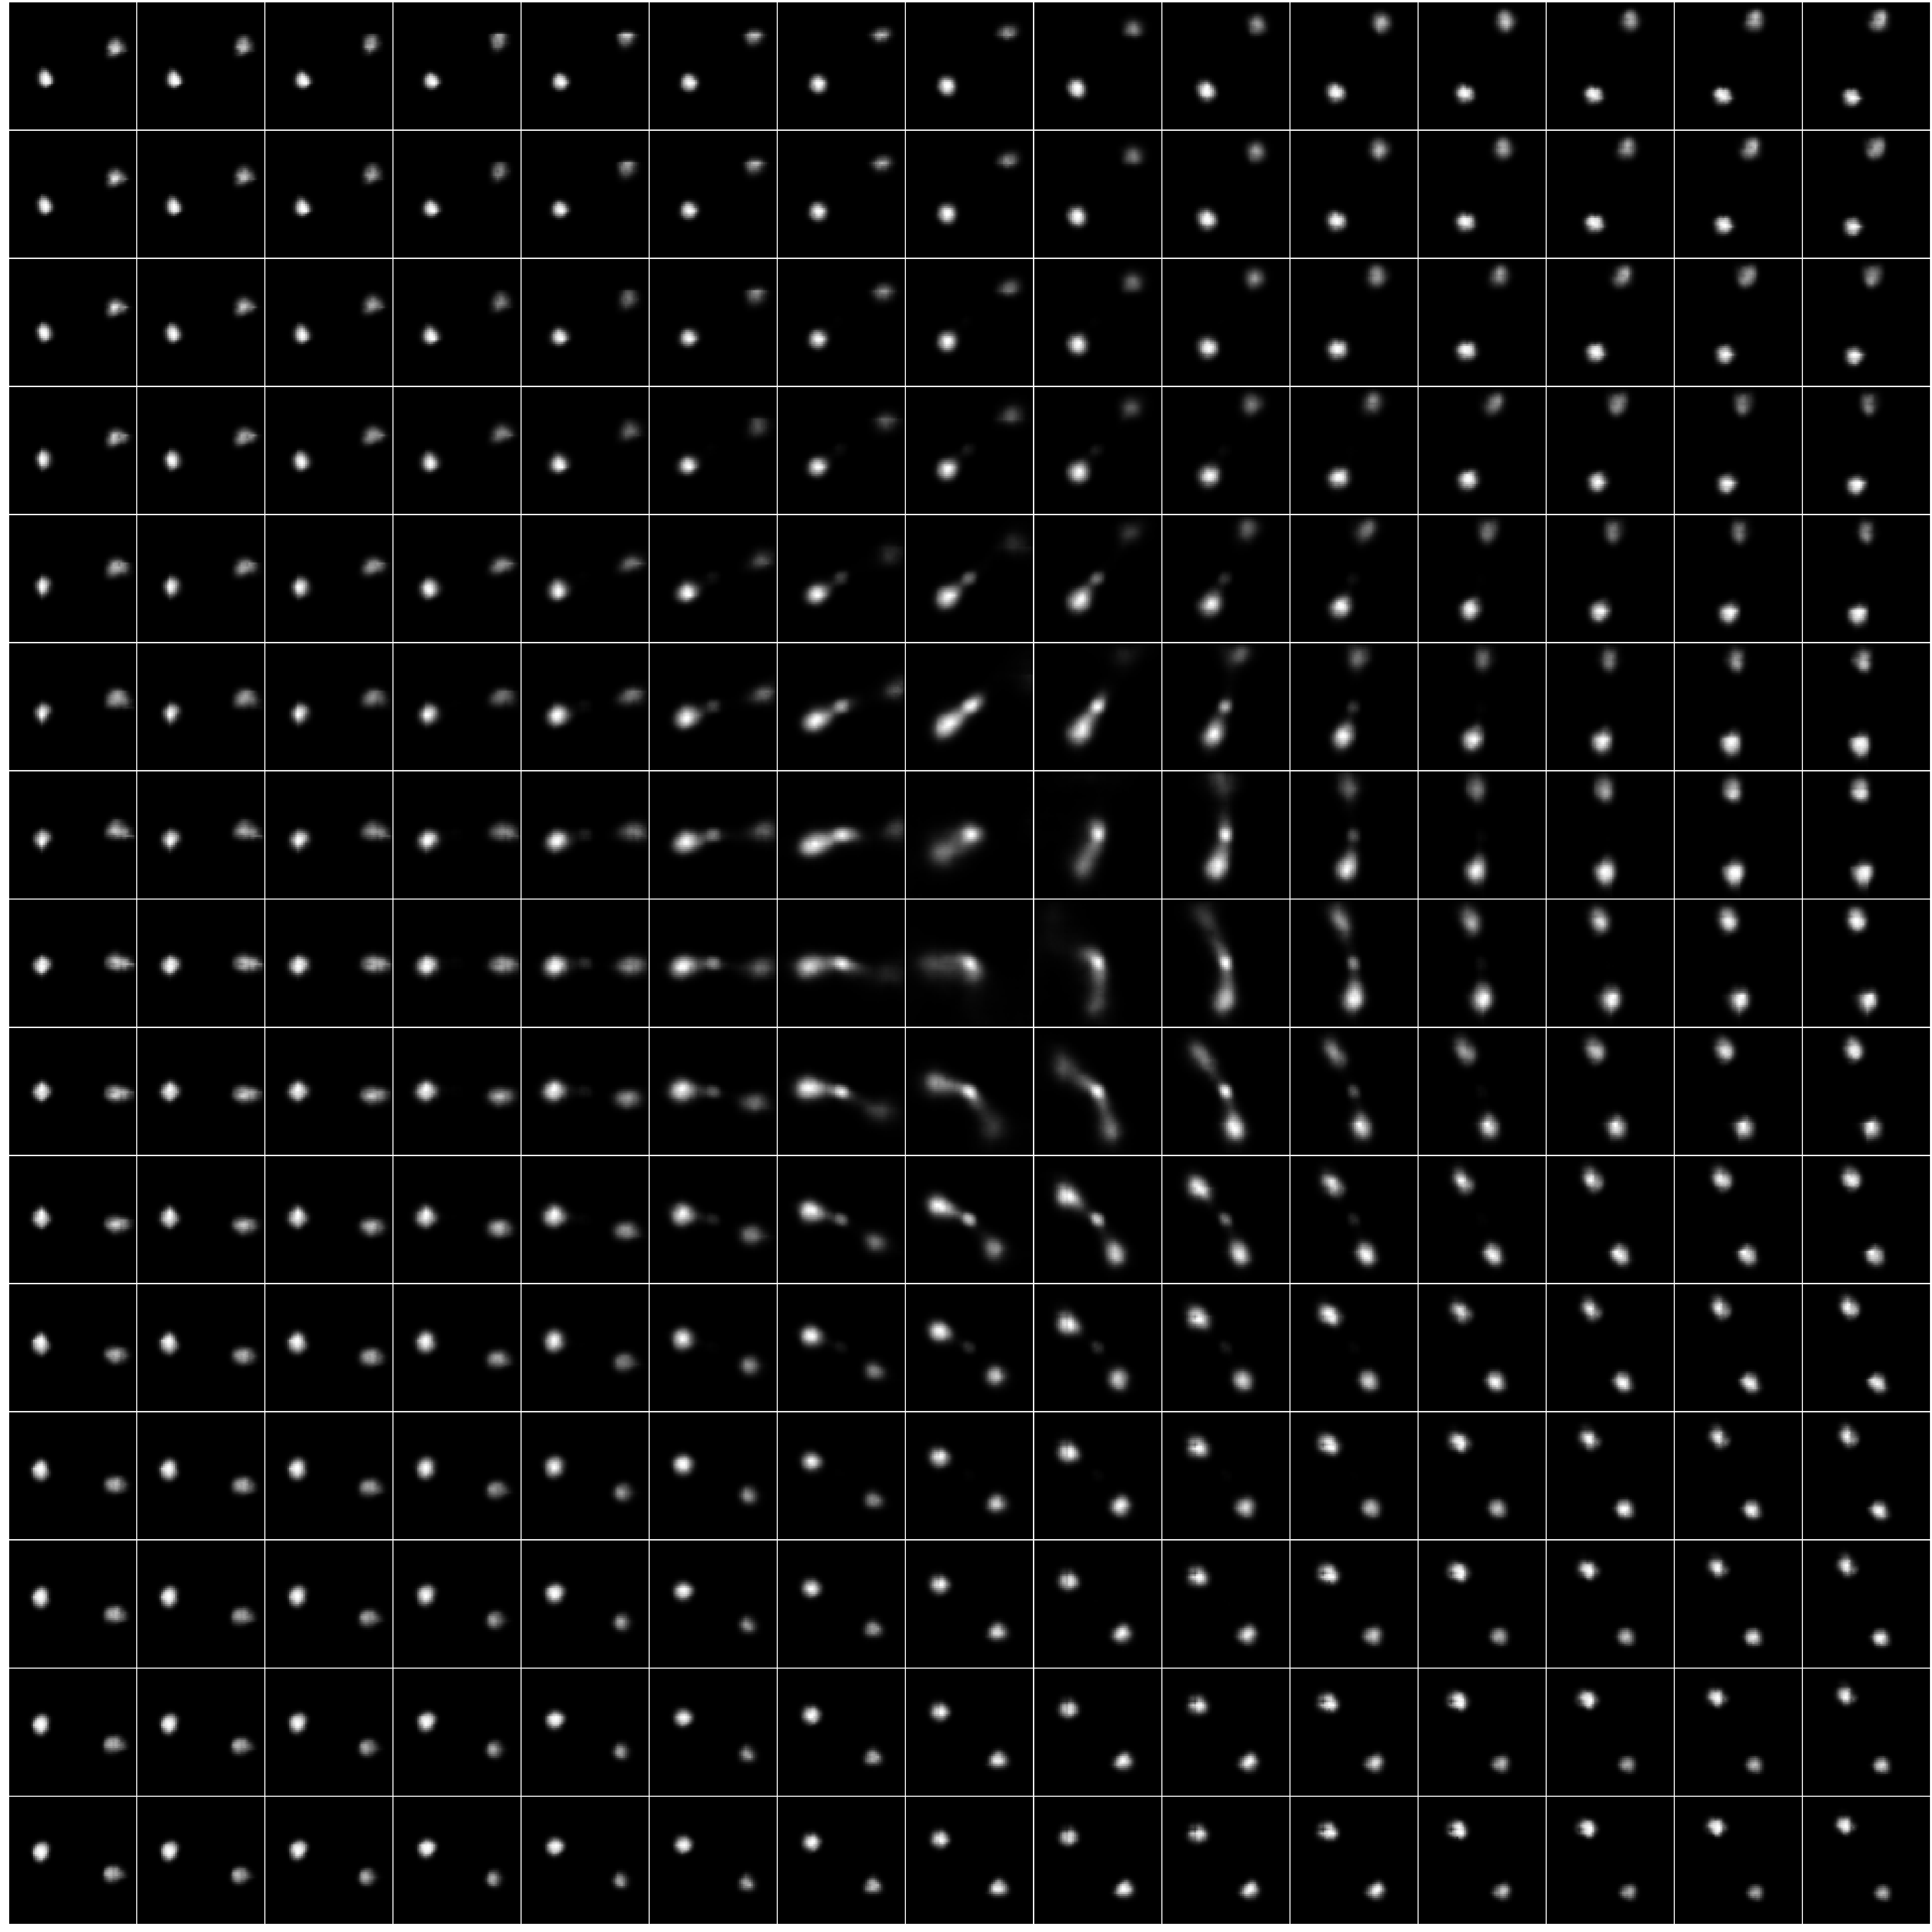

In [52]:
r = 15
nimg = r * 15
k = 1
plt.figure(figsize=(101.3, 104))
gs1 = gridspec.GridSpec(15, r)
gs1.update(wspace=0.01, hspace=0.01)

for i in range(15):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = vae.encode(s.to(device))[0][0]
            e[1] += k*(-r/2 + j)
            e[2] += k*(-r/2  + i)
            e = e[:-1]
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

In [42]:
device = 'cuda'
lt_dim = 6
# fixed values #
epochs, gam, cap = 50, 10, 10
###############
model_name = 'trained_models/b_vae_norot_unlrg_g{}_ld{}_epochs{}_cap{}'.format(gam, lt_dim, epochs, cap)
vae = torch.load(model_name, map_location = device)
vae = vae.eval()

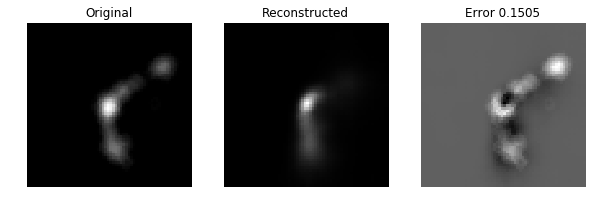

In [43]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0], cmap='gray')
ax[1].imshow(d.cpu()[0][0], cmap='gray')
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')

bce = F.binary_cross_entropy(s[0][0], d.cpu())

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('Original')
ax[1].set_title('Reconstructed')
ax[2].set_title('Error {:.4f}'.format(bce))
plt.show()

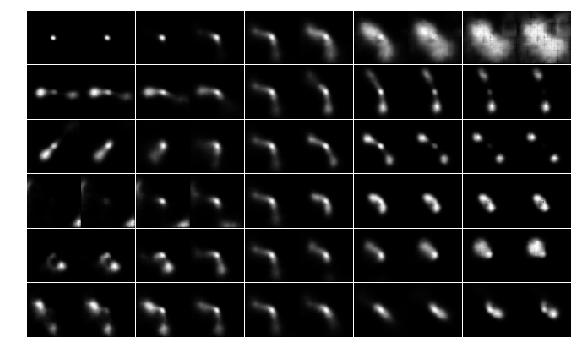

tensor([-2.3465,  0.1252,  0.7928, -0.1893, -0.3291,  1.9024], device='cuda:0')


In [44]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]

r = 10
nimg = r * lt_dim
k = 0.7
m = 1
fig = plt.figure(figsize=(58.5/lt_dim, 6))

# fig.suptitle('Lenght six feature vector', fontsize=28)
gs1 = gridspec.GridSpec(lt_dim, r, figure=fig)
gs1.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

for i in range(lt_dim):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = vae.encode(s.to(device))[0][0]
            v = e[i]
            nv = -4*k + v + k*j
            e[i] = nv
            e = e[:-1]
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

plt.show()
print(e)

In [119]:
# r = 15
# nimg = r * 15
# k = 0.5
# l = k
# plt.figure(figsize=(101.3, 104))
# gs1 = gridspec.GridSpec(15, r)
# gs1.update(wspace=0.01, hspace=0.01)

# for i in range(15):
#     for j in range(r):
#         ax1 = plt.subplot(gs1[i*r+j])
#         plt.axis('off')
#         with torch.no_grad():
#             e = torch.Tensor([1, k*(-j/2 + j), l*(-i/2  + i)]).cuda()
#             d = vae.decode(e).cpu()[0][0]
#         ax1.imshow(d, cmap='gray')
#         ax1.set_aspect('equal')

In [9]:
train_losses = []
for i in range(2, 8):
    train_file = "model_loss_data/train_loss_rot_gam_8_lt_{}.npy".format(i)
    losses = np.load(train_file,allow_pickle=True)
    train_losses.append([l.item() for l in losses])
train_losses = np.array(train_losses)

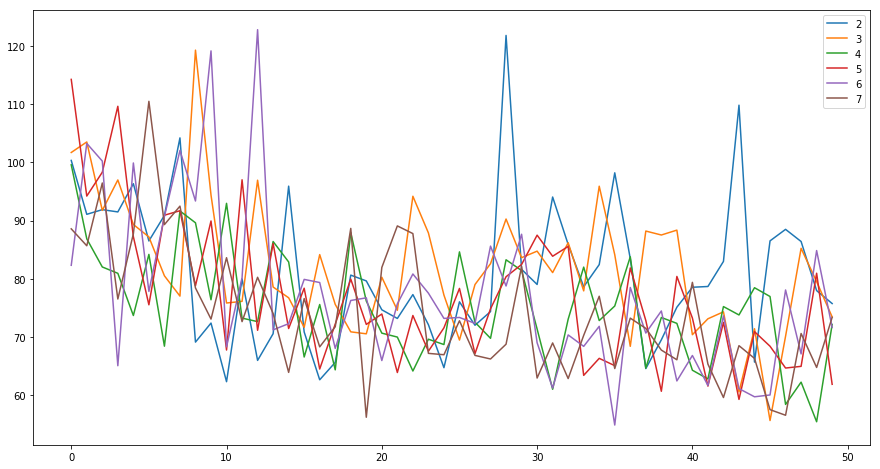

In [11]:
plt.figure(figsize=(15,8))
for i in range(2, 8):
    plt.plot(train_losses[i-2], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()

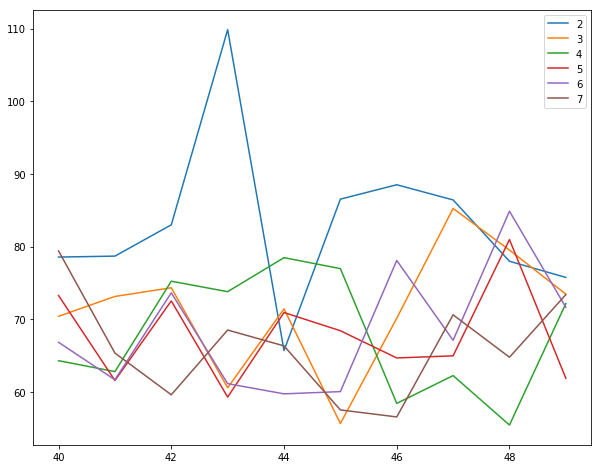

In [13]:
plt.figure(figsize=(10,8))

plt.clf()
for i in range(2, 8):
    plt.plot(np.arange(40, 50), train_losses[i-2][40:], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()

In [16]:
test_losses = []
for i in range(2, 8):
    train_file = "model_loss_data/test_loss_rot_gam_8_lt_{}.npy".format(i)
    losses = np.load(train_file,allow_pickle=True)
    test_losses.append([l.item() for l in losses])
test_losses = np.array(test_losses)

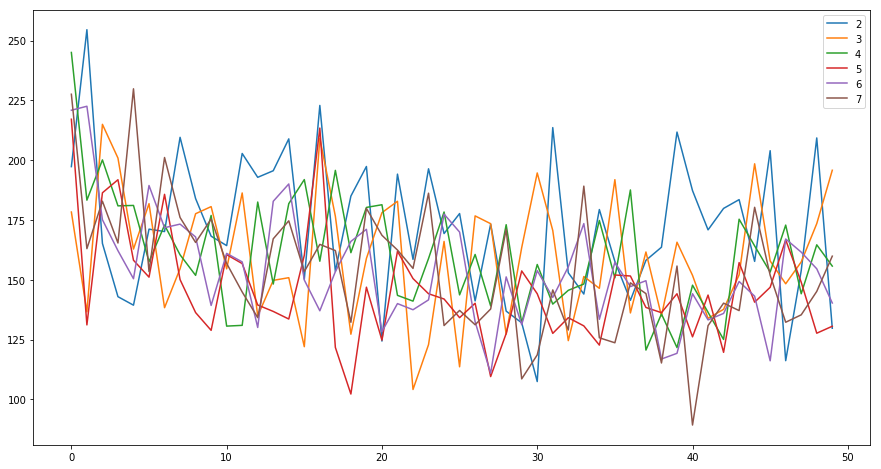

In [17]:
plt.figure(figsize=(15,8))
for i in range(2, 8):
    plt.plot(test_losses[i-2], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()

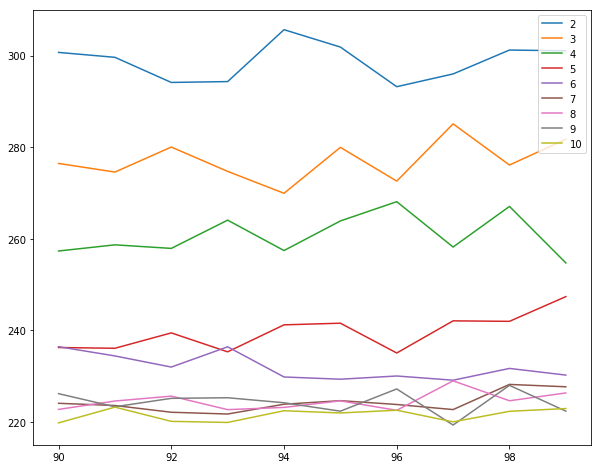

In [9]:
plt.figure(figsize=(10,8))

plt.clf()
for i in range(2, 11):
    plt.plot(np.arange(90,100), test_losses[i-2][90:], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()

In [48]:
from scipy.ndimage.interpolation import rotate

In [57]:
%%time
out = [rotate(sample[0][i,...], 90, axes=(1,2), reshape=False) for i in range(64)]

CPU times: user 41.1 ms, sys: 2.1 ms, total: 43.2 ms
Wall time: 43 ms


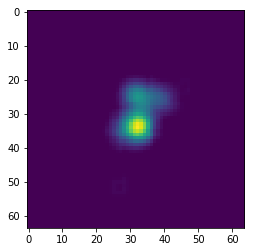

In [55]:
plt.imshow(out[0][0])

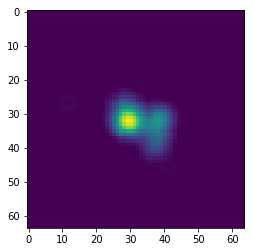

In [56]:
plt.imshow(sample[0][0][0])